In [1]:
%run Latex_macros.ipynb

<IPython.core.display.Latex object>

$$
\newcommand{\o}{\mathbf{o}}
$$


In [2]:
# My standard magic !  You will see this in almost all my notebooks.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1
%matplotlib inline

In [3]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Common imports
import os

import mnist_helper
%aimport mnist_helper

mnh = mnist_helper.MNIST_Helper()

import class_helper
%aimport class_helper

clh= class_helper.Classification_Helper()

import training_models_helper as tmh
%aimport training_models_helper

tm = tmh.TrainingModelsHelper()

num_head=5

In [4]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import linear_model, preprocessing, model_selection 
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer 
from sklearn.base import BaseEstimator, TransformerMixin

#  Multinomial Classification: from binary to many classes

What if our targets come from a class $C$  with more than two discrete values ?

The case of $|| C || > 2$ is called **Multinomial** or **Multiclass** Classification.



Some models (e.g. Decision Trees) can handle Multinomial classification directly.

For those that can't, there are two general approaches to multinomial classification
- Turn the classification task into multiple *binary* classification tasks
    - One versus All others, One versus One
- Generalize the loss function to directly accomodate multiple classes

Both approaches can be viewed as representing target $\y^\ip$ 
- as a *vector* of 1's and 0's of length $||C||$
- with exactly 1 non-zero element
- if example $i$'s target is the $j^{th}$ element of $C$
    - $\y^\ip_j = 1$
- the sum of the elements of the representation is $1$.
    
This representing of 1 out of $||C||$ is called *One Hot Encoding (OHE)* and we will discuss it in more
detail below.

This approach produces predictions $\hat{y}^\ip$
- as a vector of values in the range $[0,1]$ of length $||C||$
- whose elements sum to $1$

## Prediction as probability

Because the representations of $\y^\ip$ and $\hat{\y}^\ip$
- are of length $||C||$
- have elements in the range $[0,1]$
- and whose elements sum to $1$

both $\y^\ip$ and $\hat{\y}^\ip$ can be viewed as *probability distributions* over $||C||$ discrete values.
- $\y^\ip$ has all the probability lumped at a single value
- $\hat{\y}^\ip$ may spread the probability across multiple values
    - $\hat{\y}^\ip_j$ is the prob

Thus, rather than predicting a single value, $\hat{\y}^\ip$ assigns a probability for each possible target value in $C$
- the class of the $j^{th}$ element of $C$ is given by $\hat{\y}^\ip$

## Multinomial classification using multiple binary classifiers

### One versus all

The One versus All (OvA) method creates $||C||$ binary classifiers
- one for each $c \in C$
- the classifier for class $c$ identifies 
    - Positive examples as those having target $c$
    - Negative examples as those having targets other than $c$

For the binary classifier for class $c$, let
- $\hat{p}^{c} (\x)$  denote the prediction of example $\x$ being Positive (i.e., class $c$) made by this binary classifier


Combining the predictions for each class into a vector $\hat{p}$ of length $||C||$ such that
$$
\hat{p}_c = \hat{p}^{c} (\x)
$$

Note that the elements of $\hat{p}$ may not sum to $1$, so in order to create a probability vector
we need to normalize its elements in order to create the OvA prediction vector

$$
\hat{\y}_c (\x) = \frac{ \hat{p}^{c} (\x) } { \sum_{c' \in C} {  \hat{p}^{c'} (\x)} }
$$

That is: it normalizes the probabilities so that they sum to $1$ for each example.

**Note**

We have abused notation by using class $c$ as a subscript of $\hat{y}, \hat{p}$ rather than the integer
$j$, where $c$ is the $j^{th}$ class in $C$.

Note that the binary classifier for each class $c$ has it's own parameters $\Theta_c$.

So the number of parameters in the $\Theta$ for the OvA classifier is $||C||$ times as big
as the number of parameters for a single classifier.

### One versus one

The One versus One (OvO) method creates $\frac{||C|| * (||C|| -1 )}{2}$ binary classifiers
- one for each pair $c, c'$ of distinct values in $C$
- the classifier for pair $c, c'$ identifies 
    - Positive examples as those having target $c$
    - Negative examples as those having targets $c'$

Essentially, OvO creates a "competition" between pairs of classes for a given example $\x$
- the class that "wins" most often is chosen as the predicted class for the OvO classifier on example $\x$
 

Let's be clear on the number of coefficients estimated in One versus All:

For the digit classification problem where there are $C = 10$ classes
the number of of parameters is *10 times* that of a binary classifier.

Fortunately, `sklearn` hides all of this from you.

What you *should* realize is that $||C||$ models are being fit, each with it's own parameters.

## Softmax

A number of binary classifiers (e.g., Logistic Regression)
- produce a score
- which is then converted into a probability 

For multinomial versions of these classifiers using the One versus All scheme,
we can go directly from score to probability


For the binary classifier for class $c$, let
- $\hat{s}^{c} (\x)$  denote the score of example $\x$ produced by this binary classifier

The probability vector $\hat{y}$ can be computed by the *Softmax* function
$$
\hat{y}_c(\x) = \frac{\exp( s^{c}(\x) )}  { \sum_{c \in C} {\exp( s^{c}(\x) )}}
$$

You can see that each $\hat{y}_c(\x)  \in [0,1]$ and that
$\sum_{c \in C} { \hat{y}_c(\x) } = 1$ so $\hat{\y}$ is indeed a probablility vector.




The Softmax function is a generalization of the Sigmoid function to more than 2 classes.

By exponentiating the score, the softmax magnifies small differences in scores into larger
differenece in probability.

To illustrate: suppose we have two scores $s^c, s^{c'}$ such that
$$
\frac{s^c}{s^{c'}} = M \approx 1
$$

- If we normalize scores by dividing a score by the sum (across all scores)
    - $\frac{\hat{y}_c }{\hat{y}_{c'}}= M $
- If we normalize by softmax
    - $\frac{\hat{y}_c }{\hat{y}_{c'}} = \frac{\exp(M \hat{s}_c)}{\exp(\hat{s}^{c})} = \exp(\hat{s}_c (M-1))$

Softmax is most often seen in the context of Logistic Regression.

## Multinomial classification by generalizing the loss function

We will deal with the loss functions, both for Binary and Multinomial Classification
in a separate module.
- For Binary Classification: the loss function is called Binary Cross Entropy
- The generalization of the loss function to Multinomial Classification is called *Cross Entropy*

## Prediction for multinomial classification

Both approaches create a prediction vector $\hat{\y}$ that is a probability distribution.

If we need to choose a single target as our prediction, we can chose the one with greatest probability.
We can choose the class $c$ with the largest value in $\hat{\mathbf{p}}$ as our prediction
$$
\argmax{c \in \{1, \ldots, ||C||\} } \hat{\y}_c 
$$


# Multinomial classification example: MNIST digit classifier

Remember the digit classifier using KNN from our introductory lecture ?

We criticized the model as being one of excessive template matching: one template per training example.

We can now use Logistic Regression to obtain a classifier with *many* fewer paramters.

It will also have the benefit of helping us *interpret* **how** the classifer is making its predictions.

We won't go into interpretation until a later lecture, but for now: a preview of coming attractions.




Let's fetch the data and visualize it.

Retrieving MNIST_784 from cache


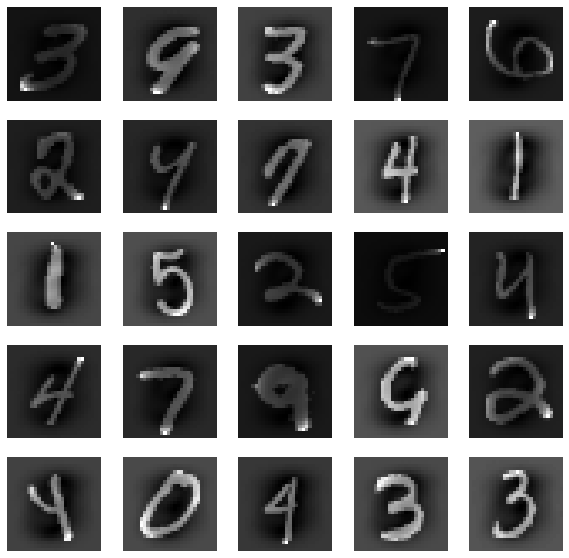

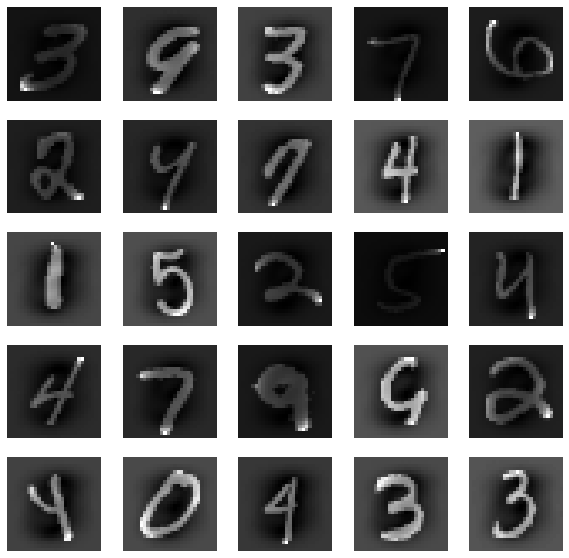

In [5]:
mnh.setup()
mnh.visualize()

In [6]:
print("Training set: X shape={xs}, y shape: {ys}".format(xs=mnh.X_train.shape, ys=mnh.y_train.shape) )
print("Training labels: y is of type {t}".format(t=type(mnh.y_train[0]) ) )

Training set: X shape=(5000, 784), y shape: (5000,)
Training labels: y is of type <class 'str'>


The training set $\X$ consists of 5000 examples, each having 784 features.

The 784 features are pixel intensity values (1=white, 0=black),  visualized as a $(28 \times 28)$ image.

Importantly, the labels (targets) are strings, i.e, string "0" rather than integer 0.
$$
C = \{ "0", "1", \ldots, "9" \}
$$

Let's fit a Logistic Regression model.

In [7]:
mnist_lr = mnh.fit()

How did we do, i.e., what was the Performance Metric ?

In [8]:
clf = mnh.clf
score = clf.score(mnh.X_test, mnh.y_test)

# How many zero coefficients were forced by the penalty ?
sparsity = np.mean(clf.coef_ == 0) * 100

print("Test score with {p} penalty:{s:.2f}".format(p=clf.penalty, s=score) )
print("Sparsity with {p} penalty: {s:.2f}.".format(p=clf.penalty, s=sparsity) )

Test score with l2 penalty:0.86
Sparsity with l2 penalty: 16.96.


We achieved an accuracy on the Test set of about 88%.

Is this good ?  We'll probe that question in a later lecture.

For now: it sounds pretty good, but
- in a Test set with equal quantities of each digit
- we could get *all* instances of a single digit wrong and still achieve 90% accuracy !
- **Lesson**: absolute numbers are mis-leading

Also notice that `LogisticRegression` used an L2 penalty (Ridge Regression) that caused
about 16% of the parameters to become $0$.

How many parameters did we fit (i.e., what is the size of $\Theta$ ?

In [9]:
print("The classifier non-intercept parameters shape: {nc};  intercept parameters shape: {ni}".format(
    nc=mnh.clf.coef_.shape,
    ni=mnh.clf.intercept_.shape
)
     )


The classifier non-intercept parameters shape: (10, 784);  intercept parameters shape: (10,)


`sklearn` separately stores
- the intercept (`clf.intercept_`): the parameter associated with the `const` column in $\X'$)
- all other parameters (`clf.coef_`) 


As you can see from the leading dimension (10) there are essentially $||C||$ binary classifiers
- one parameter per element of the feature vector
- plus one intercept/constant parameter

In total $\Theta$ has $10*(784 + 1) = 7850$ parameters.

More precisely
- The target vector $\y$ is of length $||C|| = 10$, i.e., OHE target
    - we have previously only seen scalar targets
- `LogisticRegression` is performing One versus All (OvA) classification
- Because $||\y^\ip|| > 1$, it is using a Cross Entropy Loss in the cost function


Compare this to the KNN classifier from the first lecture
- one template per example, at $(28 \times 28) = 784$ parameters per example
- times $m = 5000$ examples

So the Logistic Classifier uses about $m = 5000$ times fewer parameters.

What do the 784 non-intercept parameters look like ?

That is: what is the "template" for each class (digit) ?

Since there is one parameter per pixel, ordered in the same way as the input image pixels, we can display the 784 parameters in a $(28 \times 28)$ image.

Remember: there is one parameter vector (template) for each of the $||C|| = 10$ classes.

/home/kjp/Notebooks/NYU/mnist_helper.py:178: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  _ = fig.show()


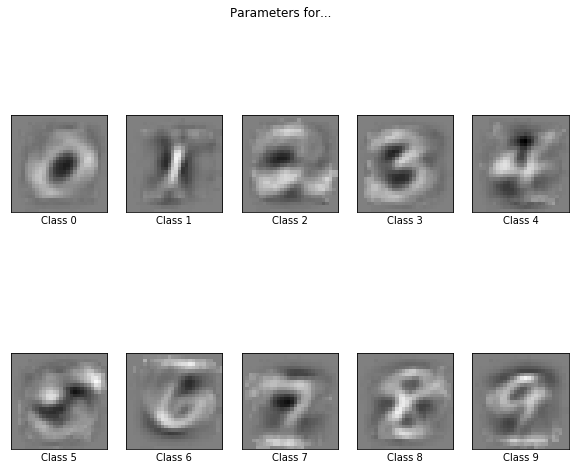

In [10]:
mnist_fig, mnist_ax = mnh.plot_coeff()

Our model learned a template, per digit, which hopefully captures the "essence" of the digit
- fuzzy, since it needs to match many possible examples of the digit, each written differently

We will "interpret" these coefficients in a subsequent lecture but, for now:
- dark colored parameters indicate the template for the pixel best matches dark input pixels
- bright colored parameters indicate the template for the pixel best matches bright input pixels

So the "essence" of an image representing the "1" digit is a vertical band of bright pixels.

<div class="alert alert-block alert-success">
<b>TIP</b>
    
The <font face=courier>fetch_mnist_784</font>
routine in the module takes a <b>long</b> time to execute.  Caching results makes you more productive.

</div>

In [11]:
print("Done")

Done
